## Check acquisition probabilities shortly after disabling MS flag for acquisition

This notebook does a quick check after about a week of data have been collected with the MS flag disabled during acquisition.  It confirms that faint sources are indeed being identified by the OBC at the expected (much higher) rate.

In [1]:
from __future__ import division

from astropy.time import Time
import matplotlib.pyplot as plt
import tables
import numpy as np
from astropy.table import Table
from chandra_aca import star_probs
%matplotlib inline

In [2]:
# Just before first obsid of FEB0816 when MS flag was disabled
# for acquisition.
tstart = Time('2016:039:09:23:10.489').cxcsec
filename = '/proj/sot/ska/data/acq_stats/acq_stats.h5'
if 'stats' not in globals():
    with tables.openFile(filename) as h5:
        stats = h5.root.data.readWhere('guide_tstart > {}'.format(tstart))
    stats = Table(stats)

    stats.sort('mag_aca')

In [3]:
def plot_n_exp_obs(stats, mag_limit=10.0, ms_enabled=True):
    idx = np.searchsorted(stats['mag_aca'], mag_limit)
    stats = stats[idx:]

    star_probs.set_fit_pars(ms_enabled)
    acq_probs = star_probs.acq_success_prob(date=stats['guide_tstart'],
                                            t_ccd=stats['ccd_temp'],
                                            mag=stats['mag_aca'],
                                            color=stats['color1'])

    n_acq = len(acq_probs)
    n_exp = np.sum(acq_probs)
    n_obs = np.sum(stats['acqid'])
    if len(acq_probs) > 30:
        print('Too many stars for computing cumulative probability (will take too long)')
        cum_n_acq_probs = None
    else:
        _, cum_n_acq_probs = star_probs.prob_n_acq(acq_probs)

    # cum_n_acq_probs[i] is probability of acquiring i or fewer
    # 1 - cum_n_acq_probs[i] is probability of acq'ing (i+1) or more
    # 1 - cum_n_acq_probs[i-1] is probability of acq'ing i or more
    print('N acq attempts = {}'.format(n_acq))
    print('Expected success = {:.2f}'.format(n_exp))
    print('Observed success = {}'.format(n_obs))
    if cum_n_acq_probs is not None:
        n = np.arange(1, n_acq)
        p = 1 - cum_n_acq_probs[n - 1]
        p0 = 1 - cum_n_acq_probs[n_obs - 1]
        plt.plot(n, p)
        plt.grid()
        print('Probability {} or more successes = {:.3g}'
             .format(n_obs, p0))
        plt.plot([n_obs, n_obs], [0, 1], '--r')
        plt.plot([n_obs], [p0], 'or')
        plt.xlabel('N success')
        plt.ylabel('Probability')
        plt.title('Probability(N or more successes)');

### Cumulative probability using the old (pre-MS-disabled) acq probability model

N acq attempts = 28
Expected success = 12.90
Observed success = 25
Probability 25 or more successes = 2.14e-07


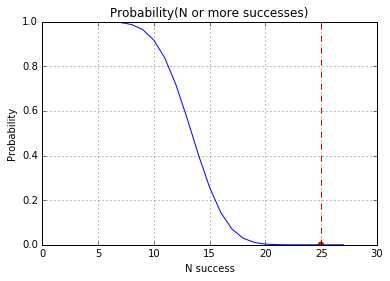

In [4]:
plot_n_exp_obs(stats, mag_limit=10.0, ms_enabled=True)

### Cumulative probability using the new (post-MS-disabled) acq probability model

N acq attempts = 28
Expected success = 22.73
Observed success = 25
Probability 25 or more successes = 0.181


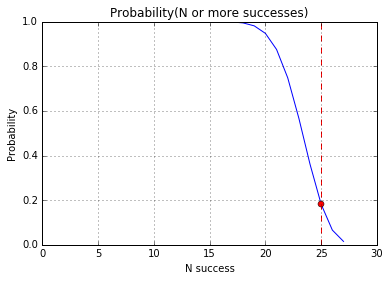

In [5]:
plot_n_exp_obs(stats, mag_limit=10.0, ms_enabled=False)